### Using Linear Regression to find Undervalued NBA Players
##### Jacob Meeker
##### 11/08/2020

### Problem Statement/Intro:

Can we find the most undervalued players in the League based on the available statistics?

In professional sports, managing money is a very important factor to the success of a team. I will be testing linear regression models on critical variables from NBA player statistics and salaries from the 2017-2018 season find where the true value lies in each NBA player. This could be a significant tool for organizations to determine whether they can acquire a player at a good value, or by players to negotiate for what they're worth.

### Datasets:

The datasets I will be using are NBA player salary dataset (2017-2018) https://www.kaggle.com/koki25ando/salary
and NBA players stats between 1950-2017 https://www.kaggle.com/drgilermo/nba-players-stats.
For this second dataset, I will only be using the data from the 2017 season. 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn import tree
from sklearn.decomposition import NMF
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn import linear_model
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from scipy.sparse import csr_matrix
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [2]:
salaries = pd.read_csv('NBA_17-18_salaries.csv')
stats = pd.read_csv('Seasons_Stats.csv')

In [3]:
# removing an unnecessary column on both datasets
salaries = salaries.drop('Unnamed: 0',axis=1)
stats = stats.drop('Unnamed: 0',axis=1)

In [4]:
# the salaries dataset is already organized from largest to smallest salary
salaries.head()

,Player,Tm,season17_18
0,Stephen Curry,GSW,34682550.0
1,LeBron James,CLE,33285709.0
2,Paul Millsap,DEN,31269231.0
3,Gordon Hayward,BOS,29727900.0
4,Blake Griffin,DET,29512900.0


In [5]:
# renaming the salaries column to make it less confusing
salaries['Salary'] = salaries['season17_18']

In [6]:
# remove years 1950-2016 as I am only interested in the 2017-2018 season. 
stats = stats[stats.Year>=2017]

There is duplicate data in both datasets that need to be addressed.
Players that were traded mid-season appear 3 times in the data;
once for their original team, once for their new team, and a third time for totals from both teams.
I want to keep the players total stats for the whole year, which is listed first in these datasets.

In [7]:
print('Player duplicated - {}'.format(any(salaries.Player.duplicated())))
print('Player duplicated - {}'.format(any(stats.Player.duplicated())))
salaries = salaries.drop_duplicates(subset=['Player'], keep='first')
stats = stats.drop_duplicates(subset=['Player'], keep='first')
print('Player duplicated - {}'.format(any(salaries.Player.duplicated())))
print('Player duplicated - {}'.format(any(stats.Player.duplicated())))

Player duplicated - True
Player duplicated - True
Player duplicated - False
Player duplicated - False


In [8]:
# to get the most value out of game statistics, stats need to be on a per-game basis 
# as opposed to total values. This eliminates the effect of games played which is a massive
# implication due to injuries, load management etc. 

stats['PPG'] = stats['PTS'] / stats['G']
stats.PPG = stats.PPG.round(1)
stats['APG'] = stats['AST'] / stats['G']
stats.APG = stats.APG.round(1)
stats['RPG'] = stats['TRB'] / stats['G']
stats.RPG = stats.RPG.round(1)
stats['SPG'] = stats['STL'] / stats['G']
stats.SPG = stats.SPG.round(1)
stats['BPG'] = stats['BLK'] / stats['G']
stats.BPG = stats.BPG.round(1)
stats['TPG'] = stats['TOV'] / stats['G']
stats.TPG = stats.TPG.round(1)
stats['MPG'] = stats['MP'] / stats['G']
stats.MPG = stats.MPG.round(1)
# creating field goal percentage column
stats['FGP'] = stats['FG'] / stats['FGA'] * 100
stats.FGP = stats.FGP.round(1)

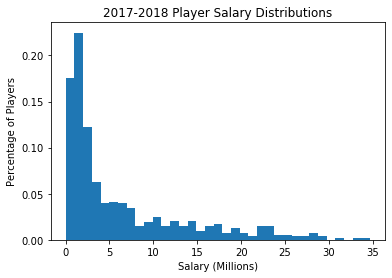

In [9]:
# simple distribution of players salaries (by million)
# as you can see, the majority of NBA players are on the lower end of the pay scale.

plt.hist(salaries.season17_18/1000000, density=True, bins=35)
plt.title('2017-2018 Player Salary Distributions')
plt.xlabel('Salary (Millions)')
plt.ylabel('Percentage of Players')
plt.show()

I made some tables to look at points per game, assists per game, and player efficiency rating leaders in the 2017-2018 season

In [10]:
stats.sort_values(by='PPG', ascending=False, inplace=True)
stats[['Player', 'PPG']].head(5)

,Player,PPG
24654,Russell Westbrook,31.6
24306,James Harden,29.1
24612,Isaiah Thomas,28.9
24218,Anthony Davis,28.0
24226,DeMar DeRozan,27.3


In [11]:
# Player Efficiency Rating
stats.sort_values(by='PER', ascending=False, inplace=True)
stats[['Player', 'PER']].head(5)

,Player,PER
24600,Jarnell Stokes,31.5
24362,Demetrius Jackson,30.8
24654,Russell Westbrook,30.6
24436,Boban Marjanovic,29.6
24239,Kevin Durant,27.6


In [12]:
stats.sort_values(by='APG', ascending=False, inplace=True)
stats[['Player', 'APG']].head(5)

,Player,APG
24306,James Harden,11.2
24646,John Wall,10.7
24654,Russell Westbrook,10.4
24522,Chris Paul,9.2
24567,Ricky Rubio,9.1


Between the two datasets there are 55 total columns. To reduce this number, first I simply removed unnecessary columns that were irrelevant to this case study or have large amounts of missing data. 

In [13]:
#*** CONSIDER REMOVING MORE TO IMPROVE RMSE. TPG FOR SURE***
stats2017 = stats[['Player','PER','BPM','FGP','RPG','APG','SPG','BPG','PPG','MPG', 'TS%', 'FT%', 'TPG', 'Age']]

# we just need the player and their corresponding salary from this dataset
salaries = salaries[['Player', 'Salary']]

# There are matching players in both datasets so these can now be merged.
all_stats = pd.merge(stats2017, salaries)
all_stats.columns

Index(['Player', 'PER', 'BPM', 'FGP', 'RPG', 'APG', 'SPG', 'BPG', 'PPG', 'MPG',
       'TS%', 'FT%', 'TPG', 'Age', 'Salary'],
      dtype='object')

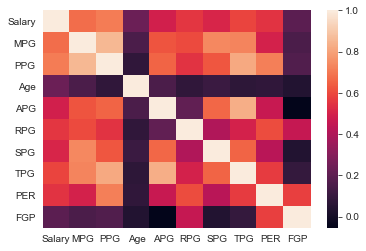

In [14]:
sns.set_style("white")

heatm = all_stats[['Salary', 'MPG', 'PPG', 'Age', 'APG', 'RPG', 'SPG', 'TPG', 'PER', 'FGP']]

heatm2 = heatm.corr()
sns.heatmap(heatm2)

I am creating subsections 'common_stats' and 'advanced_stats' and getting their RMSE and R squared values to see which will perform better in the model. 

In [15]:
common_stats=all_stats[['FGP', 'PPG', 'APG', 'RPG']]
advanced_stats=all_stats[['BPM', 'PER', 'MPG', 'TS%']]

RMSE: 5659407.056764558
R squared: 0.45076152006290326


C:\Users\phoen\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


<function matplotlib.pyplot.show(*args, **kw)>

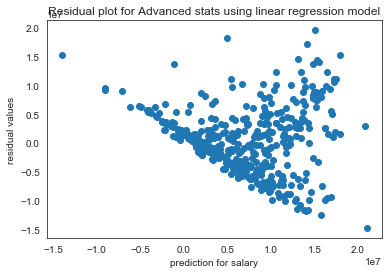

In [16]:
# Target variable (salary)
y = all_stats.Salary

# linear regression
lm = linear_model.LinearRegression()

# linear regression on the Advanced stats subset to see which scores better
X_train, X_test, y_train, y_test = train_test_split(advanced_stats, y, train_size=0.75, random_state=120)
lm.fit(X_train, y_train)
predictions = lm.predict(X_test)

# drop na values 
X_train.dropna(inplace=True)
y_train.dropna(inplace=True)

# cross validating the model 
predict = cross_val_predict(lm, advanced_stats, y, cv=6)

# get the RMSE and R^2 values
rmse = np.sqrt(mean_squared_error(predict, y))
score = metrics.r2_score(y, predict)
print('RMSE:', rmse)
print('R squared:', score)

# create a residual plot
residuals = y - predict
plt.scatter(predict, residuals)
plt.xlabel('prediction for salary')
plt.ylabel('residual values')
plt.title('Residual plot for Advanced stats using linear regression model')
plt.show

RMSE: 5369931.364836506
R squared: 0.5055110829219226


<function matplotlib.pyplot.show(*args, **kw)>

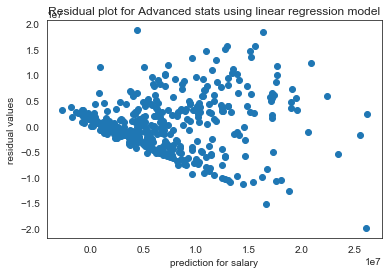

In [17]:
X_train, X_test, y_train, y_test = train_test_split(common_stats, y, train_size=0.75, random_state=120)
lm.fit(X_train, y_train)
predictions = lm.predict(X_test)

# cross validating the model 
predict = cross_val_predict(lm, common_stats, y, cv=6)

# get the RMSE and R^2 values
rmse = np.sqrt(mean_squared_error(predict, y))
score = metrics.r2_score(y, predict)
print('RMSE:', rmse)
print('R squared:', score)

# create a residual plot
residuals = y - predict
plt.scatter(predict, residuals)
plt.xlabel('prediction for salary')
plt.ylabel('residual values')
plt.title('Residual plot for Advanced stats using linear regression model')
plt.show

Common stats had a Higher R square and Lower RMSE values, so that is the subsection I decided to use
to find undervalued players

In [18]:
# positive residuals should resemble overvalued players, 
# negative should resemble undervalued players. 

# adding predicted salary and residuals columns back to dataframe
all_stats['Predicted Salary']=predict
all_stats['Residuals']=residuals

In [19]:
copy=all_stats
copy=copy[['Player', 'Residuals']]
copy=copy.sort_values('Residuals')
#top 10 undervalued players
top20=copy[:20]
top20

,Player,Residuals
93,Karl-Anthony Towns,-1.984726e+07
34,Nikola Jokic,-1.513688e+07
137,Joel Embiid,-1.267374e+07
79,Zach LaVine,-1.121365e+07
198,Kristaps Porzingis,-1.085863e+07
68,Devin Booker,-1.084392e+07
87,Jabari Parker,-1.072829e+07
217,Myles Turner,-1.047165e+07
121,Andrew Wiggins,-1.043124e+07
268,Clint Capela,-1.034877e+07


### Results

Here is The top 20 most undervalued NBA players from the 2017-2018 Season according to the analysis. This list makes a compelling argument and a large percentage of the players on the top 20 list were still on rookie contracts which are well known for being low-cost contracts. This reinforces the fact that the model is working for finding undervalued players. There are potential upgrades for this project. To make this more actionable, additional steps could be made to rank those who's contracts are expiring soon and are up for free agency. There is room for more experimentation on the feature reduction, tuning of hyperparameters, graph analysis post test/train split to see what other insights can be found. 

Additionally, sorting from the opposite side of the table should reveal which players whcih the model deems most overvalued in the 2017-18 season which could be very insightful as well. 